In [72]:
import psycopg2
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Connect to Geodatabase

In [79]:
# --- DB connection params ---
conn_params = {
    'host': 'PRIORPSRV03',
    'port': 5432,
    'dbname': 'gis',    
}

# --- Connect to Postgres ---
conn = psycopg2.connect(**conn_params)

# 2. Run SQL query to retrive required data

## Load study area LSOAs

In [80]:
# --- SQL query with schema-qualified table names ---
query = """
WITH selected_lsoas AS (
    SELECT UNNEST(ARRAY[
        'E01011284', 'E01011293', 'E01011338', 'E01011354', 'E01011355', 'E01011357', 'E01011358', 'E01011360',
        'E01011361', 'E01011363', 'E01011435', 'E01011440', 'E01011441', 'E01011442', 'E01011443', 'E01011444',
        'E01011445', 'E01011446', 'E01011447', 'E01011448', 'E01011449', 'E01011450', 'E01011451', 'E01011478',
        'E01011479', 'E01011480', 'E01011481', 'E01011482', 'E01011483', 'E01011668', 'E01011669', 'E01011670',
        'E01011671', 'E01011673', 'E01011678', 'E01011681', 'E01011691', 'E01011692', 'E01011693', 'E01032946',
        'E01033002', 'E01033003', 'E01033008', 'E01033010', 'E01033011', 'E01033013', 'E01033015', 'E01033016',
        'E01033021', 'E01033031', 'E01033033', 'E01033035', 'E01035041', 'E01035042', 'E01035043', 'E01035044',
        'E01035045', 'E01035047', 'E01035054'
    ]) AS lsoa21cd
)
SELECT 
    s.lsoa21cd,
    a.*, e.*, ep.*, eth.*, hc.*, hs.*, ht.*, ind.*, ni.*, ph.*, pp.*, rel.*, stu.*
FROM selected_lsoas s
LEFT JOIN uk_new.census2021_lsoa2021_accommodation_type       a   ON s.lsoa21cd = a.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_education               e   ON s.lsoa21cd = e.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_english_proficiency     ep  ON s.lsoa21cd = ep.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_ethnicity               eth ON s.lsoa21cd = eth.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_composition   hc  ON s.lsoa21cd = hc.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_size          hs  ON s.lsoa21cd = hs.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_housing_tenure          ht  ON s.lsoa21cd = ht.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_industry                ind ON s.lsoa21cd = ind.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_national_identity       ni  ON s.lsoa21cd = ni.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_pop_and_hholds          ph  ON s.lsoa21cd = ph.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_passport_held           pp  ON s.lsoa21cd = pp.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_religion                rel ON s.lsoa21cd = rel.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_students                stu ON s.lsoa21cd = stu.lsoa21cd;
"""

# --- Load the query result ---
df = pd.read_sql_query(query, conn)

# --- Step 1: Find and keep only the first 'lsoa21cd' column ---
# (could be 'lsoa21cd', 'lsoa21cd_1', 'lsoa21cd_2' etc.)
lsoa_cols = [col for col in df.columns if col.startswith('lsoa21cd')]
first_lsoa = lsoa_cols[0]

# --- Step 2: Drop all duplicate metadata columns and keep only the first lsoa21cd ---
columns_to_drop = [
    col for col in df.columns if col in [
        'FID', 'data_time_period', 'data_web_link',
        'msoa21cd', 'msoa21nm', 'wd22cd', 'wd22nm', 'area_ha',
        'data_source', 'lsoa21nm', 'data_resolution',
        'lad22cd','lad22nm','rgn22cd','rgn22nm', 'geometry'
    ] or (col.startswith('lsoa21cd') and col != first_lsoa)
]

# Rename the first lsoa21cd back to just 'lsoa21cd' (if it’s not already)
df = df.rename(columns={first_lsoa: 'lsoa21cd'})

# Drop everything else
df = df.drop(columns=columns_to_drop)

df.head()

# Optional save
# df.to_excel("cleaned_census_data.xlsx", index=False)

,lsoa21cd,lsoa21cd,detached_count,semi_detached_count,terraced_count,in_a_purpose_built_block_of_flats_or_tenement_count,part_of_a_converted_or_shared_house_including_bedsits_count,part_of_another_converted_building_count,in_commercial building_count,caravan_or_other_mobile_or_temporary_structure_count,detached_perc,semi_detached_perc,terraced_perc,in_a_purpose_built_block_of_flats_or_tenement_perc,part_of_a_converted_or_shared_house_including_bedsits_perc,part_of_another_converted_building_perc,in_commercial building_perc,caravan_or_other_mobile_or_temporary_structure_perc,dominant_accomodation_type_group,lsoa21cd,no_qualifications_count,level_1_and_entry_level_qualifications_count,level_2_qualifications_count,apprenticeship_count,level_3_qualifications_count,level_4_qualifications_or_above_count,other_qualifications_count,total_edu_pop_count,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,other_qualifications_perc,no_qualifications_female_count,level_1_and_entry_level_qualifications_female_count,level_2_qualifications_female_count,apprenticeship_female_count,level_3_qualifications_female_count,level_4_qualifications_or_above_female_count,other_qualifications_female_count,total_female_edu_pop_count,no_qualifications_female_perc,level_1_and_entry_level_qualifications_female_perc,level_2_qualifications_female_perc,apprenticeship_female_perc,level_3_qualifications_female_perc,level_4_qualifications_or_above_female_perc,other_qualifications_female_perc,no_qualifications_male_count,level_1_and_entry_level_qualifications_male_count,level_2_qualifications_male_count,apprenticeship_male_count,level_3_qualifications_male_count,level_4_qualifications_or_above_male_count,other_qualifications_male_count,total_male_edu_pop_count,no_qualifications_male_perc,level_1_and_entry_level_qualifications_male_perc,level_2_qualifications_male_perc,apprenticeship_male_perc,level_3_qualifications_male_perc,level_4_qualifications_or_above_male_perc,other_qualifications_male_perc,dominant_education_group,dominant_education_group_female,dominant_education_group_male,lsoa21cd,main_language_english_count,main_language_not_english_can_speak_english_very_well_count,main_language_not_english_can_speak_english_well_count,main_language_not_english_cannot_speak_english_well_count,main_language_not_english_cannot_speak_english_count,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,dominant_english_proficiency_group,lsoa21cd,asian_count,black_count,mixed_or_multiple_count,other_ethnic_count,white_count,asian_perc,black_perc,mixed_or_multiple_perc,other_ethnic_perc,white_perc,asian_bangladeshi_count,asian_chinese_count,asian_indian_count,asian_other_count,asian_pakistani_count,black_african_count,black_caribbean_count,black_other_count,mixed_or_multiple_other_count,mixed_or_multiple_white_and_asian_count,mixed_or_multiple_white_and_black_african_count,mixed_or_multiple_white_and_black_caribbean_count,other_other_count,other_arab_count,white_british_count,white_gypsy_or_irish_count,white_irish_count,white_other_count,white_roma_count,total_ethnicity_pop,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,dominant_ethnic_group,dominant_detailed_ethnic_group,lsoa21cd,one_person_count,single_family_count,other_household_types_count,one_person_perc,single_f

## Load all LSOAs in Leeds

In [81]:
query = """
WITH selected_lsoas AS (
    SELECT DISTINCT lsoa21cd
    FROM uk_new.census2021_lsoa2021_pop_and_hholds
    WHERE lad22nm = 'Leeds'
)
SELECT 
    s.lsoa21cd,
    a.*, e.*, ep.*, eth.*, hc.*, hs.*, ht.*, ind.*, ni.*, ph.*, pp.*, rel.*, stu.*
FROM selected_lsoas s
LEFT JOIN uk_new.census2021_lsoa2021_accommodation_type       a   ON s.lsoa21cd = a.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_education               e   ON s.lsoa21cd = e.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_english_proficiency     ep  ON s.lsoa21cd = ep.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_ethnicity               eth ON s.lsoa21cd = eth.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_composition   hc  ON s.lsoa21cd = hc.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_household_size          hs  ON s.lsoa21cd = hs.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_housing_tenure          ht  ON s.lsoa21cd = ht.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_industry                ind ON s.lsoa21cd = ind.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_national_identity       ni  ON s.lsoa21cd = ni.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_pop_and_hholds          ph  ON s.lsoa21cd = ph.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_passport_held           pp  ON s.lsoa21cd = pp.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_religion                rel ON s.lsoa21cd = rel.lsoa21cd
LEFT JOIN uk_new.census2021_lsoa2021_students                stu ON s.lsoa21cd = stu.lsoa21cd;
"""

# --- Load the query result ---
leeds_df = pd.read_sql_query(query, conn)
conn.close()

# --- Step 1: Find and keep only the first 'lsoa21cd' column ---
lsoa_cols = [col for col in leeds_df.columns if col.startswith('lsoa21cd')]
first_lsoa = lsoa_cols[0]

# --- Step 2: Drop all duplicate metadata columns and keep only the first lsoa21cd ---
columns_to_drop = [
    col for col in leeds_df.columns if col in [
        'FID', 'data_time_period', 'data_web_link',
        'msoa21cd', 'msoa21nm', 'wd22cd', 'wd22nm', 'area_ha',
        'data_source', 'lsoa21nm', 'data_resolution',
        'lad22cd','lad22nm','rgn22cd','rgn22nm','geometry'
    ] or (col.startswith('lsoa21cd') and col != first_lsoa)
]

# Rename and clean
leeds_df = leeds_df.rename(columns={first_lsoa: 'lsoa21cd'})
leeds_df = leeds_df.drop(columns=columns_to_drop)

# View cleaned data
leeds_df.head()

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,lsoa21cd,lsoa21cd,detached_count,semi_detached_count,terraced_count,in_a_purpose_built_block_of_flats_or_tenement_count,part_of_a_converted_or_shared_house_including_bedsits_count,part_of_another_converted_building_count,in_commercial building_count,caravan_or_other_mobile_or_temporary_structure_count,detached_perc,semi_detached_perc,terraced_perc,in_a_purpose_built_block_of_flats_or_tenement_perc,part_of_a_converted_or_shared_house_including_bedsits_perc,part_of_another_converted_building_perc,in_commercial building_perc,caravan_or_other_mobile_or_temporary_structure_perc,dominant_accomodation_type_group,lsoa21cd,no_qualifications_count,level_1_and_entry_level_qualifications_count,level_2_qualifications_count,apprenticeship_count,level_3_qualifications_count,level_4_qualifications_or_above_count,other_qualifications_count,total_edu_pop_count,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,other_qualifications_perc,no_qualifications_female_count,level_1_and_entry_level_qualifications_female_count,level_2_qualifications_female_count,apprenticeship_female_count,level_3_qualifications_female_count,level_4_qualifications_or_above_female_count,other_qualifications_female_count,total_female_edu_pop_count,no_qualifications_female_perc,level_1_and_entry_level_qualifications_female_perc,level_2_qualifications_female_perc,apprenticeship_female_perc,level_3_qualifications_female_perc,level_4_qualifications_or_above_female_perc,other_qualifications_female_perc,no_qualifications_male_count,level_1_and_entry_level_qualifications_male_count,level_2_qualifications_male_count,apprenticeship_male_count,level_3_qualifications_male_count,level_4_qualifications_or_above_male_count,other_qualifications_male_count,total_male_edu_pop_count,no_qualifications_male_perc,level_1_and_entry_level_qualifications_male_perc,level_2_qualifications_male_perc,apprenticeship_male_perc,level_3_qualifications_male_perc,level_4_qualifications_or_above_male_perc,other_qualifications_male_perc,dominant_education_group,dominant_education_group_female,dominant_education_group_male,lsoa21cd,main_language_english_count,main_language_not_english_can_speak_english_very_well_count,main_language_not_english_can_speak_english_well_count,main_language_not_english_cannot_speak_english_well_count,main_language_not_english_cannot_speak_english_count,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,dominant_english_proficiency_group,lsoa21cd,asian_count,black_count,mixed_or_multiple_count,other_ethnic_count,white_count,asian_perc,black_perc,mixed_or_multiple_perc,other_ethnic_perc,white_perc,asian_bangladeshi_count,asian_chinese_count,asian_indian_count,asian_other_count,asian_pakistani_count,black_african_count,black_caribbean_count,black_other_count,mixed_or_multiple_other_count,mixed_or_multiple_white_and_asian_count,mixed_or_multiple_white_and_black_african_count,mixed_or_multiple_white_and_black_caribbean_count,other_other_count,other_arab_count,white_british_count,white_gypsy_or_irish_count,white_irish_count,white_other_count,white_roma_count,total_ethnicity_pop,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,dominant_ethnic_group,dominant_detailed_ethnic_group,lsoa21cd,one_person_count,single_family_count,other_household_types_count,one_person_perc,single_f

# 3. Clean up retrived data

In [84]:
columns_to_keep = [
    # Identifier
    'lsoa21cd',
    
    # Education
    'no_qualifications_perc',
    'level_1_and_entry_level_qualifications_perc',
    'level_2_qualifications_perc',
    'apprenticeship_perc',
    'level_3_qualifications_perc',
    'level_4_qualifications_or_above_perc',

    # English proficiency
    'main_language_english_perc',
    'main_language_not_english_can_speak_english_very_well_perc',
    'main_language_not_english_can_speak_english_well_perc',
    'main_language_not_english_cannot_speak_english_well_perc',
    'main_language_not_english_cannot_speak_english_perc',

    # Ethnicity
    'asian_bangladeshi_perc',
    'asian_chinese_perc',
    'asian_indian_perc',
    'asian_other_perc',
    'asian_pakistani_perc',
    'black_african_perc',
    'black_caribbean_perc',
    'black_other_perc',
    'mixed_or_multiple_other_perc',
    'mixed_or_multiple_white_and_asian_perc',
    'mixed_or_multiple_white_and_black_african_perc',
    'mixed_or_multiple_white_and_black_caribbean_perc',
    'other_other_perc',
    'other_arab_perc',
    'white_british_perc',
    'white_gypsy_or_irish_perc',
    'white_irish_perc',
    'white_other_perc',
    'white_roma_perc',

    # Household composition
    'one_person_aged_66_years_and_over_perc',
    'one_person_other_perc',
    'single_family_all_aged_66_years_and_over_perc',
    'single_family_married_or_civil_partnership_perc',
    'single_family_married_or_civil_partnership_no_children_perc',
    'single_family_married_or_civil_partnership_dependant_children_p',
    'single_family_married_or_civil_partnership_nondep_children_perc',
    'single_family_cohabiting_perc',
    'single_family_cohabiting_no_children_perc',
    'single_family_cohabiting_dependant_children_perc',
    'single_family_cohabiting_nondep_children_perc',
    'single_family_lone_parent_perc',
    'single_family_lone_parent_dependant_children_perc',
    'single_family_lone_parent_nondep_children_perc',
    'single_family_other_perc',
    'other_types_dependant_children_perc',
    'other_types_all_ft_students_and_all_aged_66_years_over_perc',

    # Household size
    '0_people_in_household_perc',
    '1 person in household_perc',
    '2_people_in_household_perc',
    '3_people_in_household_perc',
    '4_people_in_household_perc',
    '5_people_in_household_perc',
    '6_people_in_household_perc',
    '7_people_in_household_perc',
    '8_or_more_people_in_household_perc',

    # Housing tenure
    'owned_perc',
    'shared_ownership_perc',
    'social_rented_perc',
    'private_rented_perc',
    'lives_rent_free_perc',
    
    # Industry
    'agriculture_energy_and_water_perc',
    'manufacturinge_perc',
    'construction_perc',
    'distribution_hotels_and_restaurants_perc',
    'transport_and_communication_perc',
    'finance_realestate_prof_admin_activity_perc',
    'public_administration_education_health_perc',
    'other_industries_perc',

    # National identity
    'any_other_combination_of_only_uk_identities_perc',
    'british_only_identity_perc',
    'cornish_and_british_only_identity_perc',
    'cornish_only_identity_perc',
    'english_and_british_only_identity_perc',
    'english_only_identity_perc',
    'irish_and_at_least_one_uk_identity_perc',
    'irish_only_identity_perc',
    'northern_irish_and_british_only_identity_perc',
    'northern_irish_only_identity_perc',
    'other_identity_and_at_least_one_uk_identity_perc',
    'other_identity_only_perc',
    'scottish_and_british_only_identity_perc',
    'scottish_only_identity_perc',
    'welsh_and_british_only_identity_perc',
    'welsh_only_identity_perc',

    # Age structure (fine-grained)
    'aged_2_years_and_under_perc',
    'aged_3_to_4_years_perc',
    'aged_5_to_7_years_perc',
    'aged_8_to_9_years_perc',
    'aged_10_to_14_years_perc',
    'aged_15_years_perc',
    'aged_16_to_17_years_perc',
    'aged_18_to_19_years_perc',
    'aged_20_to_24_years_perc',
    'aged_25_to_29_years_perc',
    'aged_30_to_34_years_perc',
    'aged_35_to_39_years_perc',
    'aged_40_to_44_years_perc',
    'aged_45_to_49_years_perc',
    'aged_50_to_54_years_perc',
    'aged_55_to_59_years_perc',
    'aged_60_to_64_years_perc',
    'aged_65_years_perc',
    'aged_66_to_69_years_perc',
    'aged_70_to_74_years_perc',
    'aged_75_to_79_years_perc',
    'aged_80_to_84_years_perc',
    'aged_85_years_and_over_perc',

    # Religion
    'buddhist_perc',
    'christian_perc',
    'hindu_perc',
    'jewish_perc',
    'muslim_perc',
    'no_religion_perc',
    'not_answered_perc',
    'other_religion_perc',
    'sikh_perc',

    # Student age groups
    'age_4_under_perc',
    'age_5_15_perc',
    'age_16_17_perc',
    'age_18_20_perc',
    'age_21_24_perc',
    'age_25_29_perc',
    'age_30_over_perc',

    # Student living arrangements
    'living_with_parents_perc',
    'living_in_communal_establishment_uni_perc',
    'living_in_communal_establishment_other_perc',
    'living_in_all_student_household_perc',
    'living_alone_perc',
    'living_in_other_household_perc',
]


In [85]:
df = df[columns_to_keep]
df_cleaned = pd.concat([
    df.iloc[:, [0]],       # keep only the first 'lsoa21cd'
    df.iloc[:, 14:]        # everything else after the first 13 columns
], axis=1)
df_cleaned.head()

,lsoa21cd,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc
0,E01011284,16.666667,10.580205,9.726962,5.005688,16.723549,37.827076,78.188900,8.276534,9.883155,3.115871,0.535540,0.270514,0.450857,1.532913,0.856628,2.569883,3.651939,0.721371,0.270514,0.946799,0.94

In [86]:
leeds_df = leeds_df[columns_to_keep]
leeds_df_cleaned = pd.concat([
    leeds_df.iloc[:, [0]],       # keep only the first 'lsoa21cd'
    leeds_df.iloc[:, 14:]        # everything else after the first 13 columns
], axis=1)
leeds_df_cleaned.head()

,lsoa21cd,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc
0,E01011264,23.593466,11.343013,13.611615,8.711434,17.876588,22.776770,97.303727,1.268834,0.872324,0.475813,0.079302,0.0,0.000000,0.155763,0.077882,0.233645,0.700935,0.077882,0.077882,0.155763,0.000000

# 4. Scale Data 

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned.iloc[:,1:])

# 5. Principle Component Analysis (PCA) to reduce dimensions

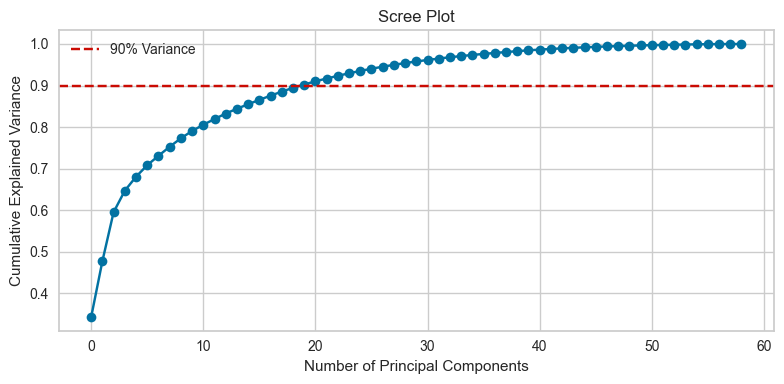

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA without limiting components
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
n_pca_components = 20  # or however many based on your scree plot
pca = PCA(n_components=n_pca_components)
X_pca = pca.fit_transform(X_scaled)

In [90]:
def get_top_features_by_pca(pca, feature_names, top_n_components=3, top_n_features=10):
    loadings = pd.DataFrame(
        pca.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )
    top_features = {}

    for pc in loadings.columns[:top_n_components]:
        top = loadings[pc].abs().sort_values(ascending=False).head(top_n_features)
        top_features[pc] = top

    return top_features

In [91]:
top_features = get_top_features_by_pca(pca, df_cleaned.iloc[:,1:].columns.tolist(), top_n_components=10, top_n_features=10)
for pc, features in top_features.items():
    print(f"\nTop features for {pc}:\n{features}")


Top features for PC1:
no_qualifications_perc                         0.145340
age_5_15_perc                                  0.144318
living_with_parents_perc                       0.144215
aged_10_to_14_years_perc                       0.141801
aged_45_to_49_years_perc                       0.141175
level_1_and_entry_level_qualifications_perc    0.140127
single_family_lone_parent_perc                 0.138355
aged_8_to_9_years_perc                         0.138270
aged_5_to_7_years_perc                         0.137880
level_2_qualifications_perc                    0.137013
Name: PC1, dtype: float64

Top features for PC2:
one_person_other_perc                                         0.199406
1 person in household_perc                                    0.195061
4_people_in_household_perc                                    0.189337
main_language_not_english_can_speak_english_very_well_perc    0.183690
5_people_in_household_perc                                    0.178800
other_identit

In [92]:
for i in range(10):
    df_cleaned[f'PC{i+1}'] = X_pca[:, i]
df_cleaned.head()

,lsoa21cd,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,E01011284,16.666667,10.580205,9.726962,5.005688,16.723549,37.827076,78.188900,8.276534,9.883155,3.115871,0.535540,0.270514,0.450857,1.532913,0.856628,2.569883

# 6. K-means

## Elbow method

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

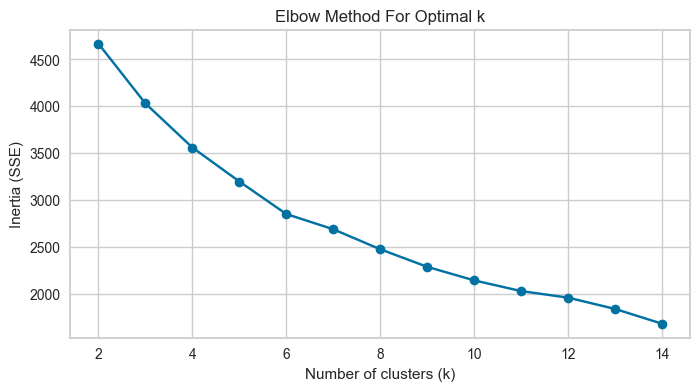

In [93]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

## Silhouette scores

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

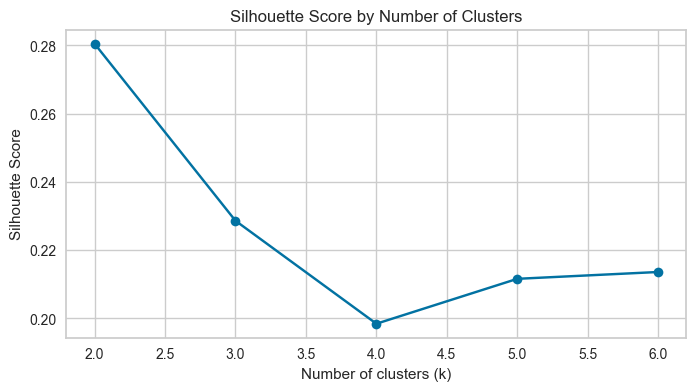

In [94]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 7)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True)
plt.show()

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMe

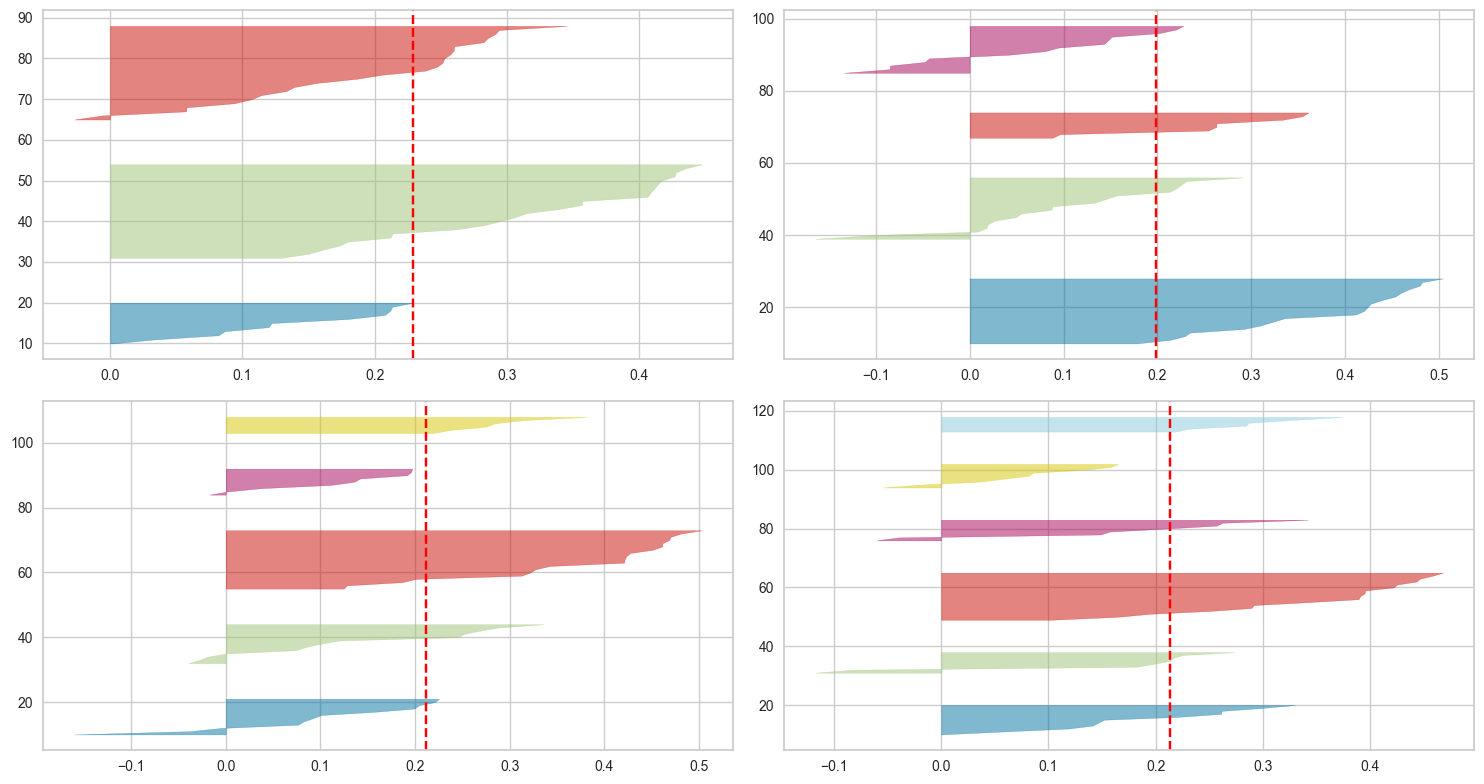

In [95]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define cluster values to test
cluster_range = [3, 4, 5, 6]

# Set up subplot grid
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()  # Flatten 2D grid to 1D for easy indexing

# Loop over cluster values and plot
for idx, k in enumerate(cluster_range):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[idx])
    visualizer.fit(X_pca)

plt.tight_layout()
plt.show()

In [96]:
k = 5  # set based on your elbow/silhouette analysis
kmeans = KMeans(n_clusters=k, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_pca)
df_cleaned.head()

C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\abhimanya.achara\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,lsoa21cd,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster
0,E01011284,16.666667,10.580205,9.726962,5.005688,16.723549,37.827076,78.188900,8.276534,9.883155,3.115871,0.535540,0.270514,0.450857,1.532913,0.856628,

# 7. Cluster profile 

In [97]:
feature_cols = [
    # Education
    'no_qualifications_perc',
    'level_1_and_entry_level_qualifications_perc',
    'level_2_qualifications_perc',
    'apprenticeship_perc',
    'level_3_qualifications_perc',
    'level_4_qualifications_or_above_perc',

    # English proficiency
    'main_language_english_perc',
    'main_language_not_english_can_speak_english_very_well_perc',
    'main_language_not_english_can_speak_english_well_perc',
    'main_language_not_english_cannot_speak_english_well_perc',
    'main_language_not_english_cannot_speak_english_perc',

    # Ethnicity
    'asian_bangladeshi_perc',
    'asian_chinese_perc',
    'asian_indian_perc',
    'asian_other_perc',
    'asian_pakistani_perc',
    'black_african_perc',
    'black_caribbean_perc',
    'black_other_perc',
    'mixed_or_multiple_other_perc',
    'mixed_or_multiple_white_and_asian_perc',
    'mixed_or_multiple_white_and_black_african_perc',
    'mixed_or_multiple_white_and_black_caribbean_perc',
    'other_other_perc',
    'other_arab_perc',
    'white_british_perc',
    'white_gypsy_or_irish_perc',
    'white_irish_perc',
    'white_other_perc',
    'white_roma_perc',

    # Household composition
    'one_person_aged_66_years_and_over_perc',
    'one_person_other_perc',
    'single_family_all_aged_66_years_and_over_perc',
    'single_family_married_or_civil_partnership_perc',
    'single_family_married_or_civil_partnership_no_children_perc',
    'single_family_married_or_civil_partnership_dependant_children_p',
    'single_family_married_or_civil_partnership_nondep_children_perc',
    'single_family_cohabiting_perc',
    'single_family_cohabiting_no_children_perc',
    'single_family_cohabiting_dependant_children_perc',
    'single_family_cohabiting_nondep_children_perc',
    'single_family_lone_parent_perc',
    'single_family_lone_parent_dependant_children_perc',
    'single_family_lone_parent_nondep_children_perc',
    'single_family_other_perc',
    'other_types_dependant_children_perc',
    'other_types_all_ft_students_and_all_aged_66_years_over_perc',

    # Household size
    '0_people_in_household_perc',
    '1 person in household_perc',
    '2_people_in_household_perc',
    '3_people_in_household_perc',
    '4_people_in_household_perc',
    '5_people_in_household_perc',
    '6_people_in_household_perc',
    '7_people_in_household_perc',
    '8_or_more_people_in_household_perc',

    # Housing tenure
    'owned_perc',
    'shared_ownership_perc',
    'social_rented_perc',
    'private_rented_perc',
    'lives_rent_free_perc',
    
    # Industry
    'agriculture_energy_and_water_perc',
    'manufacturinge_perc',
    'construction_perc',
    'distribution_hotels_and_restaurants_perc',
    'transport_and_communication_perc',
    'finance_realestate_prof_admin_activity_perc',
    'public_administration_education_health_perc',
    'other_industries_perc',

    # National identity
    'any_other_combination_of_only_uk_identities_perc',
    'british_only_identity_perc',
    'cornish_and_british_only_identity_perc',
    'cornish_only_identity_perc',
    'english_and_british_only_identity_perc',
    'english_only_identity_perc',
    'irish_and_at_least_one_uk_identity_perc',
    'irish_only_identity_perc',
    'northern_irish_and_british_only_identity_perc',
    'northern_irish_only_identity_perc',
    'other_identity_and_at_least_one_uk_identity_perc',
    'other_identity_only_perc',
    'scottish_and_british_only_identity_perc',
    'scottish_only_identity_perc',
    'welsh_and_british_only_identity_perc',
    'welsh_only_identity_perc',

    # Age structure (fine-grained)
    'aged_2_years_and_under_perc',
    'aged_3_to_4_years_perc',
    'aged_5_to_7_years_perc',
    'aged_8_to_9_years_perc',
    'aged_10_to_14_years_perc',
    'aged_15_years_perc',
    'aged_16_to_17_years_perc',
    'aged_18_to_19_years_perc',
    'aged_20_to_24_years_perc',
    'aged_25_to_29_years_perc',
    'aged_30_to_34_years_perc',
    'aged_35_to_39_years_perc',
    'aged_40_to_44_years_perc',
    'aged_45_to_49_years_perc',
    'aged_50_to_54_years_perc',
    'aged_55_to_59_years_perc',
    'aged_60_to_64_years_perc',
    'aged_65_years_perc',
    'aged_66_to_69_years_perc',
    'aged_70_to_74_years_perc',
    'aged_75_to_79_years_perc',
    'aged_80_to_84_years_perc',
    'aged_85_years_and_over_perc',

    # Religion
    'buddhist_perc',
    'christian_perc',
    'hindu_perc',
    'jewish_perc',
    'muslim_perc',
    'no_religion_perc',
    'not_answered_perc',
    'other_religion_perc',
    'sikh_perc',

    # Student age groups
    'age_4_under_perc',
    'age_5_15_perc',
    'age_16_17_perc',
    'age_18_20_perc',
    'age_21_24_perc',
    'age_25_29_perc',
    'age_30_over_perc',

    # Student living arrangements
    'living_with_parents_perc',
    'living_in_communal_establishment_uni_perc',
    'living_in_communal_establishment_other_perc',
    'living_in_all_student_household_perc',
    'living_alone_perc',
    'living_in_other_household_perc',
]


In [98]:
cluster_means = df_cleaned.groupby('cluster')[feature_cols].mean()

In [99]:
# Step 1: Calculate Leeds-wide mean and std for each feature
leeds_means = leeds_df_cleaned[feature_cols].mean() #consider changing to median
leeds_stds = leeds_df_cleaned[feature_cols].std()

# Step 2: Standardize the cluster means against Leeds-wide stats
z_profiles_vs_leeds = (cluster_means - leeds_means) / leeds_stds

In [109]:
print(leeds_means.to_string())

no_qualifications_perc                                             18.632349
level_1_and_entry_level_qualifications_perc                         9.423607
level_2_qualifications_perc                                        12.314161
apprenticeship_perc                                                 5.361798
level_3_qualifications_perc                                        17.451374
level_4_qualifications_or_above_perc                               34.358907
main_language_english_perc                                         91.427016
main_language_not_english_can_speak_english_very_well_perc          3.665695
main_language_not_english_can_speak_english_well_perc               3.117095
main_language_not_english_cannot_speak_english_well_perc            1.529684
main_language_not_english_cannot_speak_english_perc                 0.260510
asian_bangladeshi_perc                                              0.654616
asian_chinese_perc                                                  0.877471

In [100]:
# --- Define how many top features to keep (optional) ---
top_n = 10  # Set to None if you want to keep all features above 0

# --- Extract defining features (z > 0) using Leeds-wide z-scores ---
defining_features = {}

for cluster_id in z_profiles.index:
    profile = z_profiles.loc[cluster_id]
    top_features = profile[profile > 0].sort_values(ascending=False)
    if top_n:
        top_features = top_features.head(top_n)
    defining_features[cluster_id] = top_features

In [101]:
# --- Print defining features per cluster ---
for cluster_id, features in defining_features.items():
    print(f"\nCluster {cluster_id} defining features (above Leeds average):")
    print(features)# --- Combine cluster means and z-scores for reference ---
cluster_means_renamed = cluster_means.add_suffix('_mean')
z_profiles_renamed = z_profiles.add_suffix('_z')
cluster_summary = pd.concat([cluster_means_renamed, z_profiles_renamed], axis=1)


Cluster 0 defining features (above Leeds average):
asian_chinese_perc                                  1.995872
living_in_communal_establishment_uni_perc           1.981887
buddhist_perc                                       1.921466
other_identity_and_at_least_one_uk_identity_perc    1.879116
aged_18_to_19_years_perc                            1.878507
hindu_perc                                          1.855685
one_person_other_perc                               1.769451
1 person in household_perc                          1.704746
finance_realestate_prof_admin_activity_perc         1.676674
cornish_only_identity_perc                          1.637028
Name: 0, dtype: float64

Cluster 1 defining features (above Leeds average):
shared_ownership_perc               1.756635
living_in_other_household_perc      1.745729
age_30_over_perc                    1.503695
aged_30_to_34_years_perc            1.279106
transport_and_communication_perc    1.183741
lives_rent_free_perc                1

In [102]:
# Step 3: Calculate % difference vs Leeds averages
perc_diff = ((cluster_means - leeds_means) / leeds_means) * 100
perc_diff = perc_diff.add_suffix('_pct_diff')

# Step 4: Rename other DataFrames for clarity
cluster_means_renamed = cluster_means.add_suffix('_mean')
z_profiles_renamed = z_profiles.add_suffix('_z')

# Step 5: Combine everything into one cluster summary DataFrame
cluster_summary = pd.concat([cluster_means_renamed, z_profiles_renamed, perc_diff], axis=1)

In [103]:
cluster_summary.head()

,no_qualifications_perc_mean,level_1_and_entry_level_qualifications_perc_mean,level_2_qualifications_perc_mean,apprenticeship_perc_mean,level_3_qualifications_perc_mean,level_4_qualifications_or_above_perc_mean,main_language_english_perc_mean,main_language_not_english_can_speak_english_very_well_perc_mean,main_language_not_english_can_speak_english_well_perc_mean,main_language_not_english_cannot_speak_english_well_perc_mean,main_language_not_english_cannot_speak_english_perc_mean,asian_bangladeshi_perc_mean,asian_chinese_perc_mean,asian_indian_perc_mean,asian_other_perc_mean,asian_pakistani_perc_mean,black_african_perc_mean,black_caribbean_perc_mean,black_other_perc_mean,mixed_or_multiple_other_perc_mean,mixed_or_multiple_white_and_asian_perc_mean,mixed_or_multiple_white_and_black_african_perc_mean,mixed_or_multiple_white_and_black_caribbean_perc_mean,other_other_perc_mean,other_arab_perc_mean,white_british_perc_mean,white_gypsy_or_irish_perc_mean,white_irish_perc_mean,white_other_perc_mean,white_roma_perc_mean,one_person_aged_66_years_and_over_perc_mean,one_person_other_perc_mean,single_family_all_aged_66_years_and_over_perc_mean,single_family_married_or_civil_partnership_perc_mean,single_family_married_or_civil_partnership_no_children_perc_mean,single_family_married_or_civil_partnership_dependant_children_p_mean,single_family_married_or_civil_partnership_nondep_children_perc_mean,single_family_cohabiting_perc_mean,single_family_cohabiting_no_children_perc_mean,single_family_cohabiting_dependant_children_perc_mean,single_family_cohabiting_nondep_children_perc_mean,single_family_lone_parent_perc_mean,single_family_lone_parent_dependant_children_perc_mean,single_family_lone_parent_nondep_children_perc_mean,single_family_other_perc_mean,other_types_dependant_children_perc_mean,other_types_all_ft_students_and_all_aged_66_years_over_perc_mean,0_people_in_household_perc_mean,1 person in household_perc_mean,2_people_in_household_perc_mean,3_people_in_household_perc_mean,4_people_in_household_perc_mean,5_people_in_household_perc_mean,6_people_in_household_perc_mean,7_people_in_household_perc_mean,8_or_more_people_in_household_perc_mean,owned_perc_mean,shared_ownership_perc_mean,social_rented_perc_mean,private_rented_perc_mean,lives_rent_free_perc_mean,agriculture_energy_and_water_perc_mean,manufacturinge_perc_mean,construction_perc_mean,distribution_hotels_and_restaurants_perc_mean,transport_and_communication_perc_mean,finance_realestate_prof_admin_activity_perc_mean,public_administration_education_health_perc_mean,other_industries_perc_mean,any_other_combination_of_only_uk_identities_perc_mean,british_only_identity_perc_mean,cornish_and_british_only_identity_perc_mean,cornish_only_identity_perc_mean,english_and_british_only_identity_perc_mean,english_only_identity_perc_mean,irish_and_at_least_one_uk_identity_perc_mean,irish_only_identity_perc_mean,northern_irish_and_british_only_identity_perc_mean,northern_irish_only_identity_perc_mean,other_identity_and_at_least_one_uk_identity_perc_mean,other_identity_only_perc_mean,scottish_and_british_only_identity_perc_mean,scottish_only_identity_perc_mean,welsh_and_british_only_identity_perc_mean,welsh_only_identity_perc_mean,aged_2_years_and_under_perc_mean,aged_3_to_4_years_perc_mean,aged_5_to_7_years_perc_mean,aged_8_to_9_years_perc_mean,aged_10_to_14_years_perc_mean,aged_15_years_perc_mean,aged_16_to_17_years_perc_mean,aged_18_to_19_years_perc_mean,aged_20_to_24_years_perc_mean,aged_25_to_29_years_perc_mean,aged_30_to_34_years_perc_mean,aged_35_to_39_years_perc_mean,aged_40_to_44_years_perc_mean,aged_45_to_49_years_perc_mean,aged_50_to_54_years_perc_mean,aged_55_to_59_years_perc_mean,aged_60_to_64_years_perc_mean,aged_65_years_perc_mean,aged_66_to_69_years_perc_mean,aged_70_to_74_years_perc_mean,aged_75_to_79_years_perc_mean,aged_80_to_84_years_perc_mean,aged_85_years_and_over_perc_mean,buddhist_perc_mean,christian_perc_mean,hindu_perc_mean,jewish_perc_mean,muslim_perc_mean,no_religion_per

## Most Distinct Features

In [111]:
# Step 1: Prepare empty dict to store flagged features
highly_distinctive_features = {}

# Step 2: Loop through each cluster and feature
for cluster_id in z_profiles.index:
    z_row = z_profiles.loc[cluster_id]
    pct_row = cluster_summary.loc[cluster_id].filter(like='_pct_diff')
    
    # Strip suffix from column names to match features
    pct_row.index = pct_row.index.str.replace('_pct_diff', '')
    
    # Find features where both conditions are met
    mask = (z_row > 1.5) & (pct_row > 100)
    features = z_row[mask].sort_values(ascending=False)
    
    # Store results
    highly_distinctive_features[cluster_id] = features

# Step 3: Print out highly distinctive features for each cluster
for cluster_id, features in highly_distinctive_features.items():
    print(f"\nCluster {cluster_id} — Highly Distinctive Features:")
    print(features)


Cluster 0 — Highly Distinctive Features:
asian_chinese_perc                                  1.995872
living_in_communal_establishment_uni_perc           1.981887
buddhist_perc                                       1.921466
other_identity_and_at_least_one_uk_identity_perc    1.879116
aged_18_to_19_years_perc                            1.878507
hindu_perc                                          1.855685
one_person_other_perc                               1.769451
cornish_only_identity_perc                          1.637028
asian_indian_perc                                   1.626073
aged_25_to_29_years_perc                            1.602384
living_alone_perc                                   1.579819
other_arab_perc                                     1.567150
age_18_20_perc                                      1.564614
Name: 0, dtype: float64

Cluster 1 — Highly Distinctive Features:
living_in_other_household_perc    1.745729
age_30_over_perc                  1.503695
Name: 1, dtyp

## Most dominant features 

In [112]:
top_n = 10
dominant_features = {}

for cluster_id in cluster_means.index:
    row = cluster_means.loc[cluster_id]
    top_features = row.sort_values(ascending=False).head(top_n)
    dominant_features[cluster_id] = top_features

# Print results
for cluster_id, features in dominant_features.items():
    print(f"\nCluster {cluster_id} — Most Dominant Features:")
    print(features)


Cluster 0 — Most Dominant Features:
main_language_english_perc                   79.031629
private_rented_perc                          66.380511
white_british_perc                           56.362029
living_in_communal_establishment_uni_perc    53.828314
1 person in household_perc                   52.720601
no_religion_perc                             52.392739
age_18_20_perc                               51.078819
level_4_qualifications_or_above_perc         49.494574
one_person_other_perc                        49.307754
british_only_identity_perc                   42.998980
Name: 0, dtype: float64

Cluster 1 — Most Dominant Features:
main_language_english_perc              78.087581
living_with_parents_perc                53.809203
british_only_identity_perc              52.805502
white_british_perc                      49.745012
private_rented_perc                     44.373369
age_5_15_perc                           44.073104
1 person in household_perc              42.121367
le

## Count repeating dominant features

In [114]:
from collections import Counter

# dominant_features is a dict: {cluster_id: pd.Series of top features}
all_dominant = []
for features in dominant_features.values():
    all_dominant.extend(features.index.tolist())

dominant_counts = pd.Series(Counter(all_dominant)).sort_values(ascending=False)
print("\nMost Repeating Dominant Features:")
print(dominant_counts)


Most Repeating Dominant Features:
main_language_english_perc                                     5
british_only_identity_perc                                     5
white_british_perc                                             4
no_religion_perc                                               4
one_person_other_perc                                          3
private_rented_perc                                            3
living_with_parents_perc                                       3
age_5_15_perc                                                  3
level_4_qualifications_or_above_perc                           3
1 person in household_perc                                     3
christian_perc                                                 2
public_administration_education_health_perc                    2
age_18_20_perc                                                 1
living_in_communal_establishment_uni_perc                      1
living_in_all_student_household_perc                   

# Count repeating distinct features

In [115]:
all_distinctive = []
for features in highly_distinctive_features.values():
    all_distinctive.extend(features.index.tolist())

distinctive_counts = pd.Series(Counter(all_distinctive)).sort_values(ascending=False)
print("\nMost Repeating Distinctive Features:")
print(distinctive_counts)


Most Repeating Distinctive Features:
asian_chinese_perc                                             1
mixed_or_multiple_white_and_black_african_perc                 1
northern_irish_only_identity_perc                              1
welsh_only_identity_perc                                       1
asian_bangladeshi_perc                                         1
white_roma_perc                                                1
white_gypsy_or_irish_perc                                      1
black_other_perc                                               1
muslim_perc                                                    1
main_language_not_english_cannot_speak_english_well_perc       1
asian_pakistani_perc                                           1
living_in_communal_establishment_uni_perc                      1
main_language_not_english_cannot_speak_english_perc            1
black_caribbean_perc                                           1
asian_other_perc                                    

In [130]:
cluster_names = {
    0: "Post and undergraduate students living in university-managed housing with presence of international students",
    1: "Students living at home or independently in private flats",
    2: "Undergraduates in large shared houses with UK national mix",
    3: "Young families in social housing with ethnic and linguistic diversity",
    4: "Owner-occupied families with Irish heritage in public sector work"
}

# Step 2: Map those names to the cluster column in your cleaned DataFrame
df_cleaned['cluster_label'] = df_cleaned['cluster'].map(cluster_names)

# Optional preview
df_cleaned.head()

,lsoa21cd,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster,cluster_label
0,E01011284,16.666667,10.580205,9.726962,5.005688,16.723549,37.827076,78.188900,8.276534,9.883155,3.115871,0.535540,0.270514,0.450857,1.53

# 8. Add to geodatabase

In [131]:
#geopandas to process geospatial/gis data
import geopandas as gpd

lsoa2021_shapefile = r"C:\Users\abhimanya.achara\OneDrive - priorpartners.com\Documents\UK DATA\2021 Census Data\Lower_Layer_Super_Output_Areas_(Dec_2021)_Boundaries_Full_Extent_(BFE)_EW\Lower_Layer_Super_Output_Areas_(Dec_2021)_Boundaries_Full_Extent_(BFE)_EW.shp"

# Attempt to read from the server first, fallback to local path if it fails
lsoa2021boundary_df = gpd.read_file(lsoa2021_shapefile)
print("Shapefile loaded successfully from the server.")

#Drop and rename fields
lsoa2021boundary_df.drop(['Shape__Are', 'Shape__Len', 'GlobalID'], 1, inplace = True)
lsoa2021boundary_df.rename(columns = {'LSOA21CD':'lsoa21cd'}, inplace = True)
lsoa2021boundary_df.head()

Shapefile loaded successfully from the server.


C:\Users\abhimanya.achara\AppData\Local\Temp\ipykernel_12680\3967661665.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lsoa2021boundary_df.drop(['Shape__Are', 'Shape__Len', 'GlobalID'], 1, inplace = True)


,FID,lsoa21cd,LSOA21NM,geometry
0,1,E01000001,City of London 001A,"POLYGON ((532151.537 181867.433, 532152.500 18..."
1,2,E01000002,City of London 001B,"POLYGON ((532634.497 181926.016, 532632.048 18..."
2,3,E01000003,City of London 001C,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,4,E01000005,City of London 001E,"POLYGON ((533619.062 181402.364, 533639.868 18..."
4,5,E01000006,Barking and Dagenham 016A,"POLYGON ((545126.852 184310.838, 545145.213 18..."


In [132]:
final_data = pd.merge(lsoa2021boundary_df,df_cleaned,how = 'right', on ='lsoa21cd')
final_data.drop(['FID','LSOA21NM'],1,inplace = True)
final_data.head()

C:\Users\abhimanya.achara\AppData\Local\Temp\ipykernel_12680\2943046521.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_data.drop(['FID','LSOA21NM'],1,inplace = True)


,lsoa21cd,geometry,no_qualifications_perc,level_1_and_entry_level_qualifications_perc,level_2_qualifications_perc,apprenticeship_perc,level_3_qualifications_perc,level_4_qualifications_or_above_perc,main_language_english_perc,main_language_not_english_can_speak_english_very_well_perc,main_language_not_english_can_speak_english_well_perc,main_language_not_english_cannot_speak_english_well_perc,main_language_not_english_cannot_speak_english_perc,asian_bangladeshi_perc,asian_chinese_perc,asian_indian_perc,asian_other_perc,asian_pakistani_perc,black_african_perc,black_caribbean_perc,black_other_perc,mixed_or_multiple_other_perc,mixed_or_multiple_white_and_asian_perc,mixed_or_multiple_white_and_black_african_perc,mixed_or_multiple_white_and_black_caribbean_perc,other_other_perc,other_arab_perc,white_british_perc,white_gypsy_or_irish_perc,white_irish_perc,white_other_perc,white_roma_perc,one_person_aged_66_years_and_over_perc,one_person_other_perc,single_family_all_aged_66_years_and_over_perc,single_family_married_or_civil_partnership_perc,single_family_married_or_civil_partnership_no_children_perc,single_family_married_or_civil_partnership_dependant_children_p,single_family_married_or_civil_partnership_nondep_children_perc,single_family_cohabiting_perc,single_family_cohabiting_no_children_perc,single_family_cohabiting_dependant_children_perc,single_family_cohabiting_nondep_children_perc,single_family_lone_parent_perc,single_family_lone_parent_dependant_children_perc,single_family_lone_parent_nondep_children_perc,single_family_other_perc,other_types_dependant_children_perc,other_types_all_ft_students_and_all_aged_66_years_over_perc,0_people_in_household_perc,1 person in household_perc,2_people_in_household_perc,3_people_in_household_perc,4_people_in_household_perc,5_people_in_household_perc,6_people_in_household_perc,7_people_in_household_perc,8_or_more_people_in_household_perc,owned_perc,shared_ownership_perc,social_rented_perc,private_rented_perc,lives_rent_free_perc,agriculture_energy_and_water_perc,manufacturinge_perc,construction_perc,distribution_hotels_and_restaurants_perc,transport_and_communication_perc,finance_realestate_prof_admin_activity_perc,public_administration_education_health_perc,other_industries_perc,any_other_combination_of_only_uk_identities_perc,british_only_identity_perc,cornish_and_british_only_identity_perc,cornish_only_identity_perc,english_and_british_only_identity_perc,english_only_identity_perc,irish_and_at_least_one_uk_identity_perc,irish_only_identity_perc,northern_irish_and_british_only_identity_perc,northern_irish_only_identity_perc,other_identity_and_at_least_one_uk_identity_perc,other_identity_only_perc,scottish_and_british_only_identity_perc,scottish_only_identity_perc,welsh_and_british_only_identity_perc,welsh_only_identity_perc,aged_2_years_and_under_perc,aged_3_to_4_years_perc,aged_5_to_7_years_perc,aged_8_to_9_years_perc,aged_10_to_14_years_perc,aged_15_years_perc,aged_16_to_17_years_perc,aged_18_to_19_years_perc,aged_20_to_24_years_perc,aged_25_to_29_years_perc,aged_30_to_34_years_perc,aged_35_to_39_years_perc,aged_40_to_44_years_perc,aged_45_to_49_years_perc,aged_50_to_54_years_perc,aged_55_to_59_years_perc,aged_60_to_64_years_perc,aged_65_years_perc,aged_66_to_69_years_perc,aged_70_to_74_years_perc,aged_75_to_79_years_perc,aged_80_to_84_years_perc,aged_85_years_and_over_perc,buddhist_perc,christian_perc,hindu_perc,jewish_perc,muslim_perc,no_religion_perc,not_answered_perc,other_religion_perc,sikh_perc,age_4_under_perc,age_5_15_perc,age_16_17_perc,age_18_20_perc,age_21_24_perc,age_25_29_perc,age_30_over_perc,living_with_parents_perc,living_in_communal_establishment_uni_perc,living_in_communal_establishment_other_perc,living_in_all_student_household_perc,living_alone_perc,living_in_other_household_perc,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster,cluster_label
0,E01011284,"POLYGON ((427258.094 434519.906, 427281.649 43...",16.666667,10.580205,9.726962,5.005688,16.723549,37.827076,78.1889

In [133]:
final_data.shape

(59, 144)

In [134]:
#library for connecting to the geodatabase
from sqlalchemy import create_engine, text
from geoalchemy2 import Geometry

# Define database connection parameters
db_host = "PRIORPSRV03"
db_name = "gis"
db_port = "5432"
db_schema = "university_of_leeds"
table_name = "geopersona_clusters"  # Desired table name
primary_key_column = "lsoa21cd"  # Define the primary key column (change based on your dataset)
geometry_column = "geometry"  # Default geometry column
# Create the database connection string (Windows Authentication - Trusted Connection)
conn_str = f"postgresql+psycopg2://@{db_host}:{db_port}/{db_name}?sslmode=disable"

# Create a SQLAlchemy engine
engine = create_engine(conn_str)

In [135]:
# Ensure the GeoDataFrame has a valid CRS before writing
if final_data.crs is None:
    print("Warning: GeoDataFrame has no CRS. Setting default to EPSG:27700 (British National Grid).")
    final_data.set_crs(epsg=27700, inplace=True)

In [136]:
# Publish the GeoDataFrame to PostGIS
final_data.to_postgis(
    name=table_name,
    con=engine,
    schema=db_schema,
    if_exists="replace",
    index=False,
    dtype={'geometry': 'MULTIPOLYGON'}  # Ensure geometry is stored as MULTIPOLYGON
)

print(f"Data successfully uploaded to PostGIS: {db_schema}.{table_name}")

# Connect to the database to modify table structure
with engine.connect() as conn:
    # Set Primary Key (if it doesn't exist already)
    alter_pk_query = text(f"""
        ALTER TABLE {db_schema}.{table_name}
        ADD CONSTRAINT {table_name}_pkey PRIMARY KEY ({primary_key_column});
    """)
    
    # Create Spatial Index
    create_spatial_index_query = text(f"""
        CREATE INDEX {table_name}_geom_idx
        ON {db_schema}.{table_name}
        USING GIST ({geometry_column});
    """)

    try:
        conn.execute(alter_pk_query)  # Add Primary Key
        print(f"Primary key set on column: {primary_key_column}")
    except Exception as e:
        print(f"Could not set primary key. It may already exist. Error: {e}")

    try:
        conn.execute(create_spatial_index_query)  # Add Spatial Index
        print(f"Spatial index created for geometry column: {geometry_column}")
    except Exception as e:
        print(f"Could not create spatial index. It may already exist. Error: {e}")

print(f"GeoDataFrame successfully published to PostGIS with Primary Key and Spatial Index: {db_schema}.{table_name}")

Data successfully uploaded to PostGIS: university_of_leeds.geopersona_clusters
Primary key set on column: lsoa21cd
Spatial index created for geometry column: geometry
GeoDataFrame successfully published to PostGIS with Primary Key and Spatial Index: university_of_leeds.geopersona_clusters
